<a href="https://www.kaggle.com/code/danuherath/loan-approval-predict-binary-classification?scriptVersionId=218266818" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align="center"> Loan Approval Prediction (Binary Classification)</h1>

<img 
    src="https://www.kaggle.com/competitions/84894/images/header" 
    alt="" 
    width="300" 
    height="200" 
    style="display: block; margin: 0 auto; border-radius:15px" 
/>

---

## Problem Definition

- Domain

    - Banking | Finance

<br>

- Dataset

    - [Loan Approval Prediction](https://www.kaggle.com/competitions/playground-series-s4e10/data) dataset from Kaggle which contains 11 features explaining loan applicants' demographics, income details and loan details. Train dataset contains 58,645 samples and each instance represents one applicant.

<br>

- Objective

    - The goal of this project is to predict whether an applicant is approved for a loan.
    
<br>

- Algorithms

    - Following classification algorithms are used to train models on the train dataset. The models are evaluated using the [Area Under the Receiver Operating Characteristic Curve (ROC AUC)](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html) metric.
    
        1. [XGBoost (Extreme Gradient Boosting) Classifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)
        2. [LightGBM Classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
        3. [CatBoost Classifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
%config InlineBackend.figure_format="svg"

from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score

import optuna

RSEED = 42

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")


In [3]:
train_data.head()


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test_data.head()


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [5]:
train_data.drop(columns=["id"], inplace=True)
test_data.drop(columns=["id"], inplace=True)


---
# Step 1: Exploratory Data Analysis (EDA)
---

In [6]:
print(f"Train Data\nInstance Count: {train_data.shape[0]} \nFeature Count: {train_data.shape[1]-1}")

train_data.head().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"'
    ).set_properties(**{'min-width': '50px'})


Train Data
Instance Count: 58645 
Feature Count: 11


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.000000,EDUCATION,B,6000,11.490000,0.170000,N,14,0
1,22,56000,OWN,6.000000,MEDICAL,C,4000,13.350000,0.070000,N,2,0
2,29,28800,OWN,8.000000,PERSONAL,A,6000,8.900000,0.210000,N,10,0
3,30,70000,RENT,14.000000,VENTURE,B,12000,11.110000,0.170000,N,5,0
4,22,60000,RENT,2.000000,MEDICAL,A,6000,6.920000,0.100000,N,3,0


In [7]:
print(f"Test Data\nInstance Count: {test_data.shape[0]} \nFeature Count: {test_data.shape[1]-1}")

test_data.head().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"'
    ).set_properties(**{'min-width': '50px'})


Test Data
Instance Count: 39098 
Feature Count: 10


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,RENT,3.000000,HOMEIMPROVEMENT,F,25000,15.760000,0.360000,N,2
1,26,96000,MORTGAGE,6.000000,PERSONAL,C,10000,12.680000,0.100000,Y,4
2,26,30000,RENT,5.000000,VENTURE,E,4000,17.190000,0.130000,Y,2
3,33,50000,RENT,4.000000,DEBTCONSOLIDATION,A,7000,8.900000,0.140000,N,7
4,26,102000,MORTGAGE,8.000000,HOMEIMPROVEMENT,D,15000,16.320000,0.150000,Y,4


In [8]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


In [9]:
missing_values = train_data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values)  


Series([], dtype: int64)


In [10]:
duplicates = train_data[train_data.duplicated(keep=False)]
print(len(duplicates))


0


In [11]:
train_data.nunique().sort_values(ascending=False)


person_income                 2641
loan_amnt                      545
loan_int_rate                  362
loan_percent_income             61
person_age                      53
person_emp_length               36
cb_person_cred_hist_length      29
loan_grade                       7
loan_intent                      6
person_home_ownership            4
cb_person_default_on_file        2
loan_status                      2
dtype: int64

In [12]:
cat_features = train_data.select_dtypes(include=["object"]).columns.tolist()
num_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns:\n{cat_features}")
print(f"\nNumerical columns:\n{num_features}")


Categorical columns:
['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

Numerical columns:
['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']


In [13]:
num_features.remove("loan_status")
target = "loan_status"


In [14]:
for col in cat_features:
    print(col)
    print(dict(train_data[col].value_counts()))
    print()


person_home_ownership
{'RENT': 30594, 'MORTGAGE': 24824, 'OWN': 3138, 'OTHER': 89}

loan_intent
{'EDUCATION': 12271, 'MEDICAL': 10934, 'PERSONAL': 10016, 'VENTURE': 10011, 'DEBTCONSOLIDATION': 9133, 'HOMEIMPROVEMENT': 6280}

loan_grade
{'A': 20984, 'B': 20400, 'C': 11036, 'D': 5034, 'E': 1009, 'F': 149, 'G': 33}

cb_person_default_on_file
{'N': 49943, 'Y': 8702}



In [15]:
target_counts = train_data[target].value_counts()
target_counts


loan_status
0    50295
1     8350
Name: count, dtype: int64

---
## 1.1 Statistical Analysis
---

In [16]:
train_data[num_features].describe().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"').set_properties(**{'min-width': '100px'})


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,64046.172871,4.701015,9217.556518,10.677874,0.159238,5.813556
std,6.033216,37931.106978,3.959784,5563.807384,3.034697,0.091692,4.029196
min,20.000000,4200.000000,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,42000.000000,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,58000.000000,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,75600.000000,7.000000,12000.000000,12.990000,0.210000,8.000000
max,123.000000,1900000.000000,123.000000,35000.000000,23.220000,0.830000,30.000000


In [17]:
Q1 = train_data[num_features].quantile(0.25)
Q3 = train_data[num_features].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((train_data[num_features] < lower_bound) | (train_data[num_features] > upper_bound))

outliers_count = outliers_iqr.sum()
outliers_count = outliers_count[outliers_count > 0].sort_values(ascending=False)
print(f"Outliers Count: \n{outliers_count}")


Outliers Count: 
person_age                    2446
person_income                 2411
loan_amnt                     2045
cb_person_cred_hist_length    1993
person_emp_length             1274
loan_percent_income           1210
loan_int_rate                   34
dtype: int64


---
## 1.2 Data Visualization
---

---
## 1.2.1 Univariate Analysis¶
---

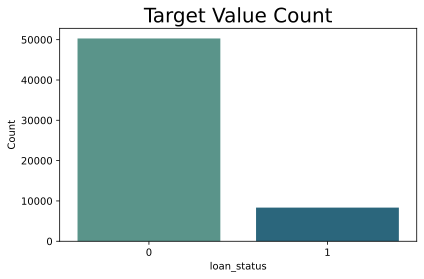

In [18]:
target_counts = train_data[target].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="crest")
plt.ylabel("Count")
plt.title("Target Value Count", fontsize=20)
plt.tight_layout()
plt.show()


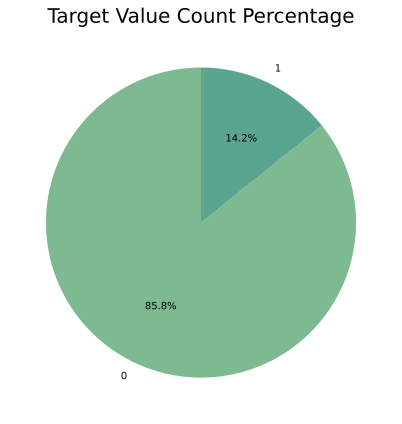

In [19]:
target_counts = train_data[target].value_counts()

plt.figure(figsize=(6,6))
plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("crest"))
plt.title("Target Value Count Percentage", fontsize=20)
plt.tight_layout()
plt.show()


In [20]:
len(cat_features)


4

In [21]:
n_rows_cat = 2
n_cols_cat = 2


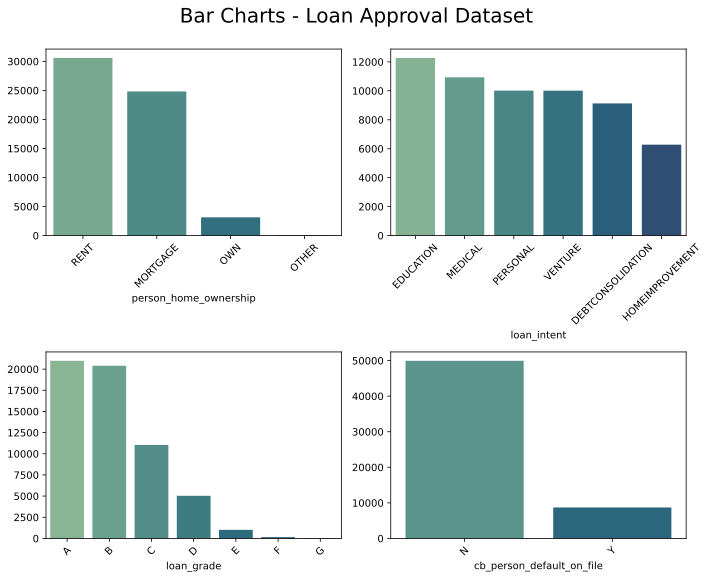

In [22]:
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(10, 4*n_rows_cat))
axes = axes.flatten()

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    category_counts = train_data[cat_features][column].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, palette="crest")
    ax.set_xticklabels(category_counts.index, rotation=45)
    

plt.suptitle("Bar Charts - Loan Approval Dataset", fontsize=20, y=1.0)
plt.tight_layout()
plt.savefig("Categorical Feature Analysis - Bar Charts.svg")
plt.show()


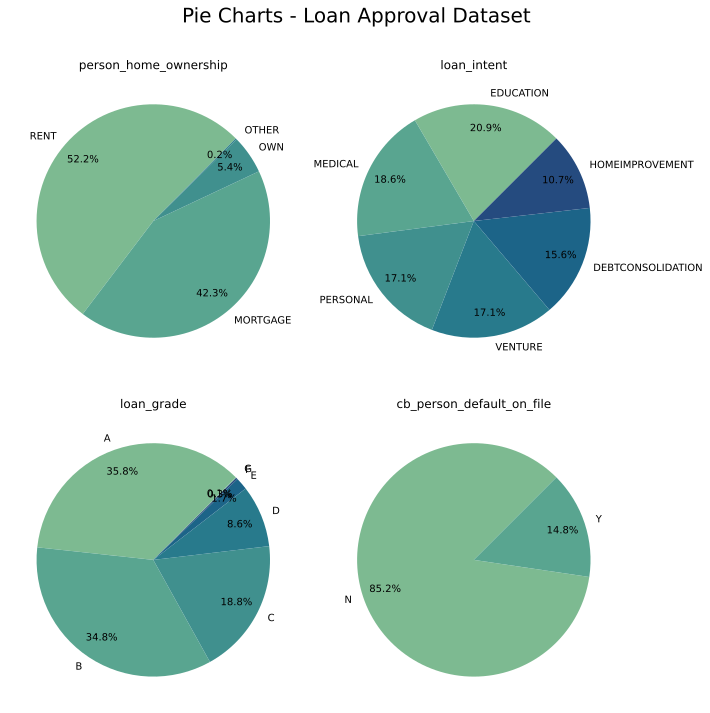

In [23]:
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(10, 5*n_rows_cat))
axes = axes.flatten()

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    category_counts = train_data[cat_features][column].value_counts()
    ax.pie(
        category_counts.values, 
        labels=category_counts.index, 
        autopct='%1.1f%%', 
        startangle=45, 
        colors=sns.color_palette('crest'), 
        labeldistance=1.1,
        pctdistance=0.80
    )
    ax.set_title(column)

plt.suptitle('Pie Charts - Loan Approval Dataset', fontsize=20, y=1.0)
plt.tight_layout()
plt.savefig("Categorical Feature Analysis - Pie Charts.svg")
plt.show()


In [24]:
len(num_features)


7

In [25]:
n_cols_num = 2
n_rows_num = 4


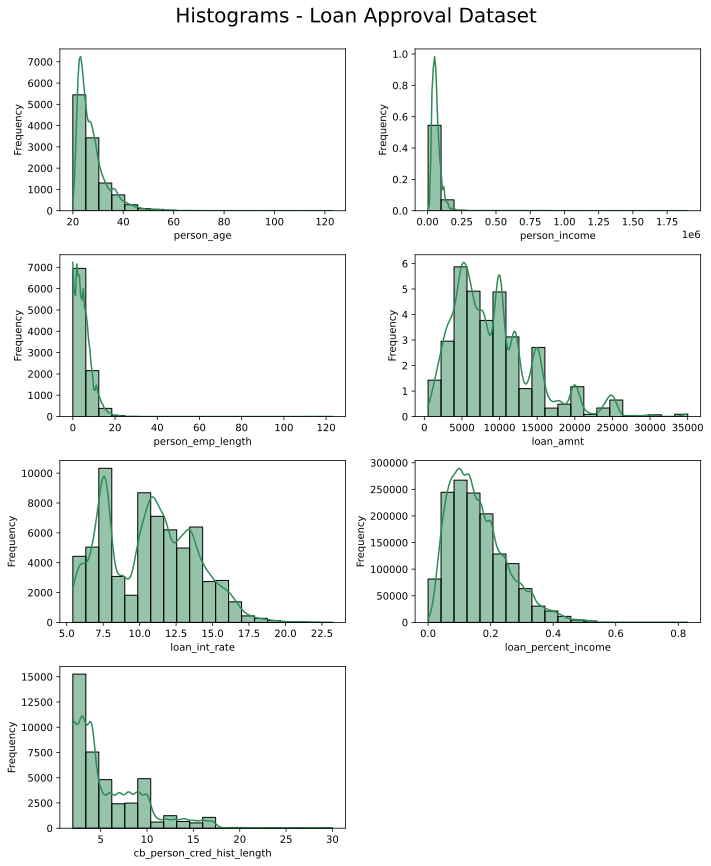

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axes = plt.subplots(n_rows_num, n_cols_num, figsize=(10, 3*n_rows_num))
axes = axes.flatten()

for i, col in enumerate(train_data[num_features].columns):
    ax = axes[i]
    sns.histplot(train_data[num_features][col], ax=ax, color='seagreen', stat='frequency', bins=20, kde=True)
    ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle('Histograms - Loan Approval Dataset', fontsize=20, y=1.0)
plt.tight_layout()
plt.savefig('Numerical Feature Analysis - Histograms.svg')
plt.show()


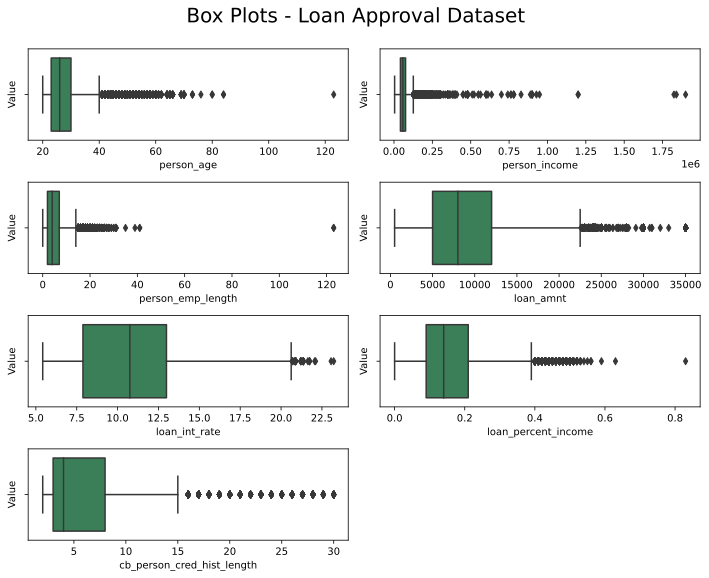

In [27]:
fig, axes = plt.subplots(n_rows_num, n_cols_num, figsize=(10, 2*n_rows_num))
axes = axes.flatten()

for i, col in enumerate(train_data[num_features].columns):
    ax = axes[i]
    sns.boxplot(x=train_data[num_features][col], ax=ax, color='seagreen')
    ax.set_xlabel(col)
    ax.set_ylabel('Value')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle('Box Plots - Loan Approval Dataset', fontsize=20, y=1.0)
plt.tight_layout()
plt.savefig('Numerical Feature Analysis - Box Plots.svg')
plt.show()


---
## 1.2.2 Bivariate Analysis
---

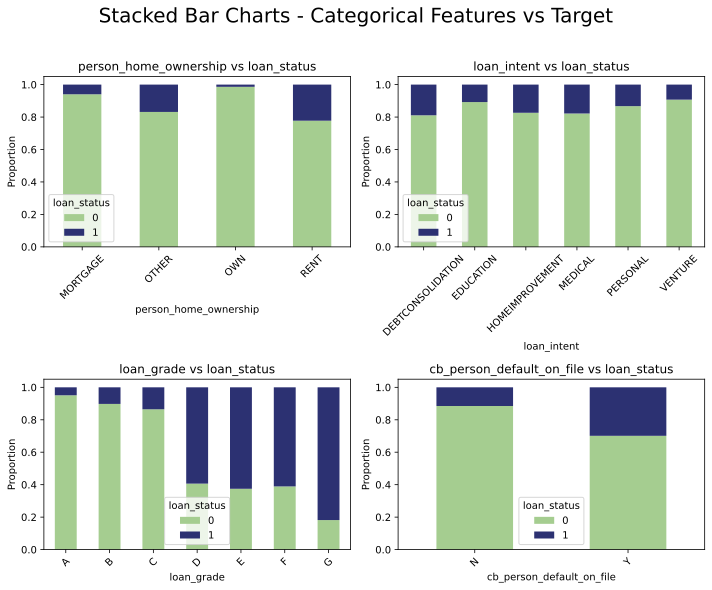

In [28]:
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(10, 4*n_rows_cat))
axes = axes.flatten()

colors = sns.color_palette("crest", as_cmap=True)

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    cross_tab_data = pd.crosstab(train_data[column], train_data[target], normalize='index')
    cross_tab_data.plot(kind='bar', stacked=True, ax=ax, cmap=colors)
    ax.set_title(f"{column} vs {target}")
    ax.set_xlabel(column)
    ax.set_ylabel("Proportion")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.suptitle("Stacked Bar Charts - Categorical Features vs Target", fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig("Categorical Features vs Target Analysis - Stacked Bar Charts.svg")
plt.show()


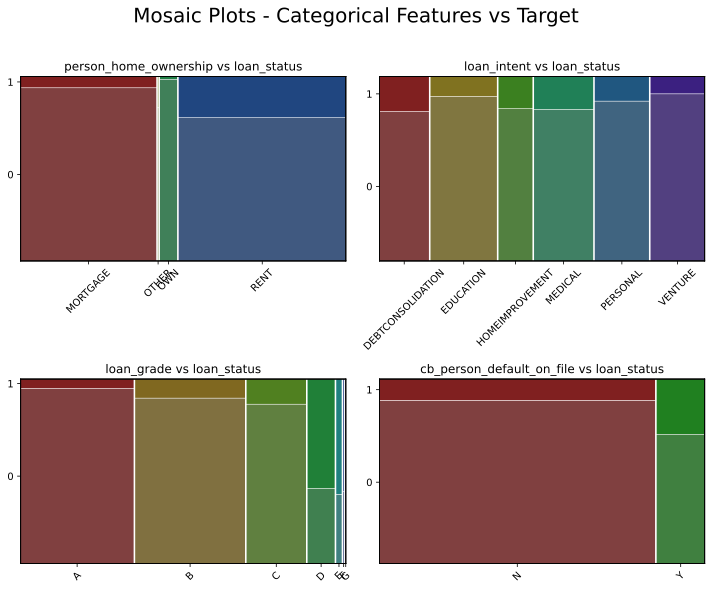

In [29]:
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(10, 4*n_rows_cat))
axes = axes.flatten()

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    mosaic_data = pd.crosstab(train_data[column], train_data[target]).stack()
    mosaic(mosaic_data, ax=ax, labelizer=lambda k: "")
    ax.set_title(f"{column} vs {target}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.suptitle("Mosaic Plots - Categorical Features vs Target", fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig("Categorical Features vs Target Analysis - Mosaic Plots.svg")
plt.show()


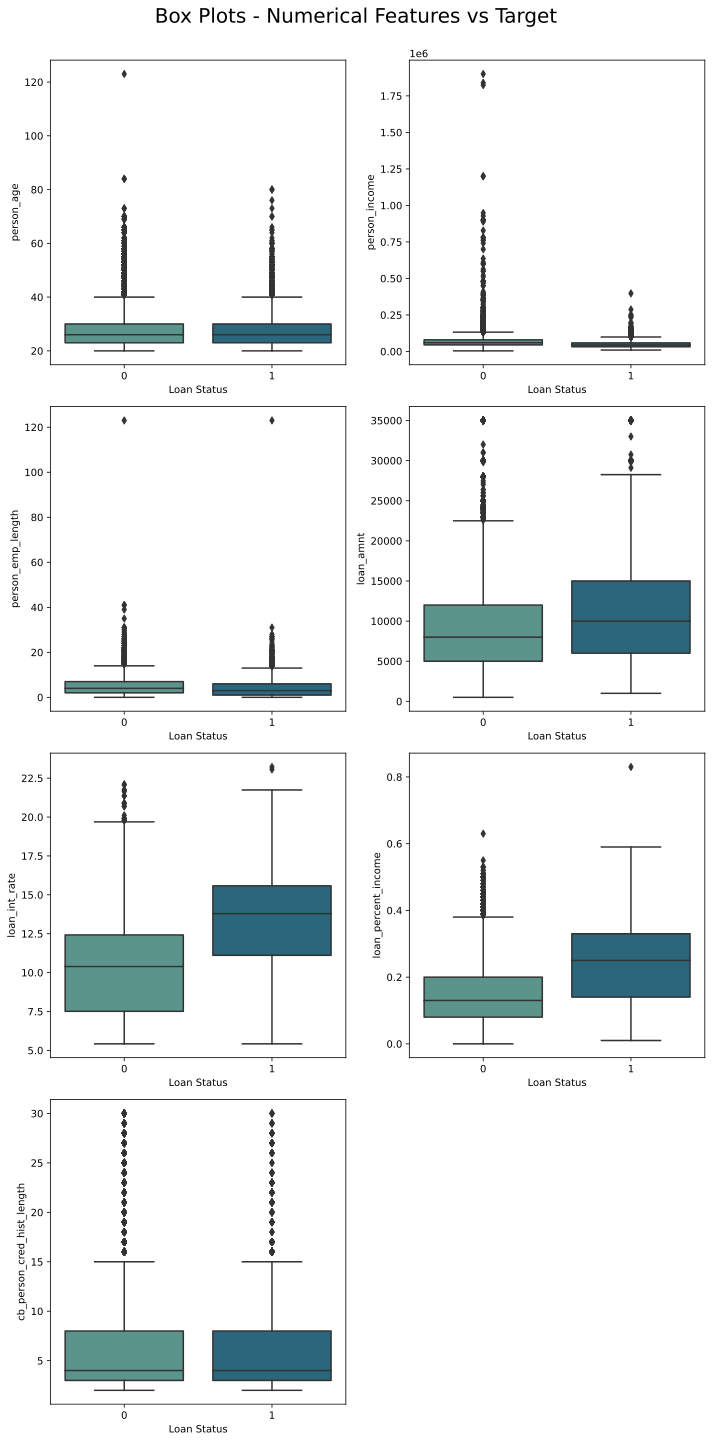

In [30]:
fig, axes = plt.subplots(n_rows_num, n_cols_num, figsize=(10, 5*n_rows_num))
axes = axes.flatten()

for i, col in enumerate(train_data[num_features].columns):
    ax = axes[i]
    sns.boxplot(x=train_data[target], y=train_data[col], ax=ax, palette="crest")
    ax.set_xlabel("Loan Status")
    ax.set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Box Plots - Numerical Features vs Target', fontsize=20, y=1.0)
plt.tight_layout()
plt.savefig('Numerical Features vs Target Analysis - Box Plots.svg')
plt.show()


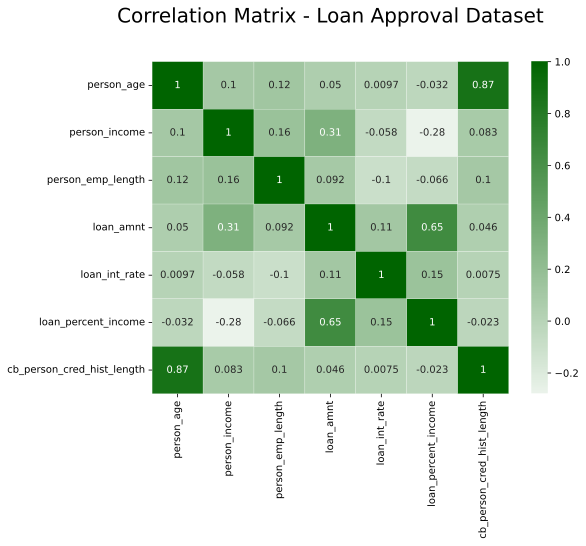

In [31]:
corr = train_data[num_features].corr()
cmap = sns.light_palette("darkgreen", as_cmap=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap=cmap, linewidths=0.2)

plt.title('Correlation Matrix - Loan Approval Dataset', fontsize=20, y=1.1)
plt.savefig('Numerical Features Correlation Analysis - Corr Matrix.svg')
plt.show()


---
# Step 2: Data Preprocessing
---

In [32]:
# SimpleImputer - for missing values
# RobustScaler - for outliers
# OneHotEncoder - for categorical data encodeing

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(steps=[
            ('scaler', RobustScaler())
        ]), num_features),

        ('categorical', Pipeline(steps=[
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), cat_features)

    ],
    remainder='passthrough'
)

preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length']),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['person_home_ownership', 'loan_intent',
                                  'loan_grade', 'cb_person_default_on_file'])])

In [33]:
train_data_transformed = pd.DataFrame(
    preprocessor.fit_transform(train_data),
    columns=preprocessor.get_feature_names_out()
)
train_data_transformed.head()


,numerical__person_age,numerical__person_income,numerical__person_emp_length,numerical__loan_amnt,numerical__loan_int_rate,numerical__loan_percent_income,numerical__cb_person_cred_hist_length,categorical__person_home_ownership_OTHER,categorical__person_home_ownership_OWN,categorical__person_home_ownership_RENT,...,categorical__loan_intent_PERSONAL,categorical__loan_intent_VENTURE,categorical__loan_grade_B,categorical__loan_grade_C,categorical__loan_grade_D,categorical__loan_grade_E,categorical__loan_grade_F,categorical__loan_grade_G,categorical__cb_person_default_on_file_Y,remainder__loan_status
0,1.571429,-0.684524,-0.8,-0.285714,0.144814,0.250000,2.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.571429,-0.059524,0.4,-0.571429,0.508806,-0.583333,-0.4,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.428571,-0.869048,0.8,-0.285714,-0.362035,0.583333,1.2,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.571429,0.357143,2.0,0.571429,0.070450,0.250000,0.2,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.571429,0.059524,-0.4,-0.285714,-0.749511,-0.333333,-0.2,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X = train_data_transformed.iloc[:, :-1]
y = train_data_transformed.iloc[:, -1]


In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RSEED)


In [36]:
smote_tomek = SMOTETomek(random_state=RSEED)

X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

print(X_resampled.shape)
print(y_resampled.shape)
print(y_resampled.value_counts())


(74968, 22)
(74968,)
remainder__loan_status
0.0    37484
1.0    37484
Name: count, dtype: int64


---
# Step 3: Model Training & Evaluation
---

In [37]:
class_weights = [1, 1]  # [weight for class 0, weight for class 1]

model = CatBoostClassifier(class_weights=class_weights, eval_metric="AUC", iterations=1000, learning_rate=0.1, depth=6, random_state=RSEED)

model.fit(X_resampled, y_resampled, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=100)

0:	test: 0.9002565	best: 0.9002565 (0)	total: 74.2ms	remaining: 1m 14s
100:	test: 0.9415125	best: 0.9415125 (100)	total: 1.74s	remaining: 15.5s
200:	test: 0.9488569	best: 0.9488569 (200)	total: 3.41s	remaining: 13.6s
300:	test: 0.9516415	best: 0.9516415 (300)	total: 5.05s	remaining: 11.7s
400:	test: 0.9529697	best: 0.9530697 (388)	total: 6.66s	remaining: 9.95s
500:	test: 0.9536598	best: 0.9538395 (484)	total: 8.29s	remaining: 8.26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9538394872
bestIteration = 484

Shrink model to first 485 iterations.


In [38]:
y_pred = model.predict(X_val)
auc = roc_auc_score(y_val, y_pred)
print(auc)

0.8605405378424431


---
# Step 4: Test Data Prediction
---

In [39]:
test_data = preprocessor.fit_transform(test_data)


In [40]:
test_predictions = model.predict(test_data)
test_predictions

array([1., 0., 1., ..., 0., 0., 1.])

In [41]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
submission[target] = test_predictions

submission.to_csv('submission.csv', index=False)

submission.head()

,id,loan_status
0,58645,1.0
1,58646,0.0
2,58647,1.0
3,58648,0.0
4,58649,0.0
